In [1]:
'''
Differential Gene Expression Comparison between Predicted Cell Type
Labels and True Marker Genes
'''

'\nDifferential Gene Expression Comparison between Predicted Cell Type\nLabels and True Marker Genes\n'

In [1]:
import pandas as pd
import os
import random
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from tqdm import tqdm

from contextlib import contextmanager
import psutil
import time

import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import random

import json
from adjustText import adjust_text

tqdm.pandas()

In [9]:
HUMAN_EMBEDS_PQ = '/large_storage/ctc/userspace/rohankshah/homo_sapiens.parquet'
HUMAN_CT_FP = '/large_storage/goodarzilab/arshian/state_ct_obs/Homo_sapiens'
HUMAN_SRX_DIR = '/large_storage/ctc/public/scBasecamp/GeneFull_Ex50pAS/GeneFull_Ex50pAS/Homo_sapiens'
META_FP = '/large_storage/ctc/public/scBasecamp/metadata_tsp_annotated_2.parquet'
DE_GENES_FP = 'de_genes'

if not os.path.exists(DE_GENES_FP):
    os.mkdir(DE_GENES_FP)

In [3]:
# Get the metadata
raw_metadata = pd.read_parquet(META_FP)
# Filter for quality
metadata_filtered = raw_metadata[(raw_metadata['organism'] == 'Homo sapiens') & (raw_metadata['mean_umi_per_cell'] > 100)].copy()
annotated_srxs = [filename.replace('.parquet', '') for filename in os.listdir(HUMAN_CT_FP)]
plain_srxs = [filename.replace('.h5ad', '') for filename in os.listdir(HUMAN_SRX_DIR)]

# Get metadata srxs with annotated srxs
overlapping_srxs = set(metadata_filtered['srx_accession'].values).intersection(set(annotated_srxs)).intersection(set(plain_srxs))
metadata = metadata_filtered[metadata_filtered['srx_accession'].isin(overlapping_srxs)].copy()

In [4]:
def sample_srxs(metadata, num_cells, tissue=None):
    if tissue:
        metadata_subset = metadata[metadata['tissue_tsp'] == tissue].copy()
    else:
        total_srxs = []
        for tissue in metadata['tissue_tsp'].unique():
            tissue_srxs = sample_srxs(metadata, num_cells, tissue=tissue)
            total_srxs += tissue_srxs
        return total_srxs
    
    random.seed(42)
    shuffled_srxs = list(metadata_subset['srx_accession'].values)
    random.shuffle(shuffled_srxs)
    
    sampled_srxs = []
    total_cells = 0
    
    for srx in shuffled_srxs:
        if total_cells >= num_cells:
            break
        srx_cells = metadata_subset[metadata_subset['srx_accession'] == srx]['estimated_number_of_cells'].iloc[0]
        sampled_srxs.append(srx)
        total_cells += srx_cells
    print(f"{total_cells} cells")
    
    return sampled_srxs

def extract_rows_by_srx(parquet_path, srx_list):
    """
    Extract all rows from STATE embeddings parquet file whose 'dataset' column matches any SRX in `srx_list`
    """
    srx_set = set(srx_list)
    pf = pq.ParquetFile(parquet_path)
    
    print(f"Scanning {pf.num_row_groups} row groups for {len(srx_set)} SRX accessions...")

    matched_tables = []
    for i in tqdm(range(pf.num_row_groups), desc="Scanning row groups"):
        dataset_column = pf.read_row_group(i, columns=['dataset'])['dataset']
        dataset_list = dataset_column.to_pylist()

        # Find matching row indices in this row group
        matched_indices = [j for j, srx in enumerate(dataset_list) if srx in srx_set]

        if matched_indices:
            # Extract only matching rows in row group
            full_table = pf.read_row_group(i)
            matched_table = full_table.take(matched_indices)
            matched_tables.append(matched_table)

    if not matched_tables:
        raise ValueError("No matching rows found for given SRXs.")
    
    print(f"Found {sum(t.num_rows for t in matched_tables)} total rows across all SRXs")
    final_table = pa.concat_tables(matched_tables)
    df = final_table.to_pandas()
    return df

def get_state_adatas(srxs, embeds_dir, ct_dir, srx_dir):
    embeds_df = extract_rows_by_srx(embeds_dir, srxs)
    print(f"Loaded {len(embeds_df)} embedding rows, {len(embeds_df.columns)} columns")
    embeds_df['unique_cell'] = embeds_df['dataset'] + '_' + embeds_df['cell']
    embeds_df = embeds_df.set_index('unique_cell').drop(['cell', 'dataset'], axis=1)
    print(f"Processed to {embeds_df.shape[0]} cells, {embeds_df.shape[1]} features")
        
    def load_ct(srx):
        ct_df = pd.read_parquet(f"{ct_dir}/{srx}.parquet")
        ct_df.index = srx + '_' + ct_df.index.astype(str)
        return ct_df
    
    cell_types_list = []
    expression_list = []
    
    for srx in tqdm(set(srxs), desc="Loading cell types and expression"):
        cell_types_list.append(load_ct(srx))
        
        h5ad_path = f"{srx_dir}/{srx}.h5ad"
        adata_srx = ad.read_h5ad(h5ad_path)
        adata_srx.obs.index = srx + '_' + adata_srx.obs.index.astype(str)
        expression_list.append(adata_srx)

    all_cell_types = pd.concat(cell_types_list)
    all_expression = ad.concat(expression_list)
    print(f"Total cell types: {len(all_cell_types)}")
    print(f"Total expression cells: {all_expression.n_obs}")
    
    common_cells = embeds_df.index.intersection(all_cell_types.index).intersection(all_expression.obs.index)
    print(f"Found {len(common_cells)} overlapping cells")
    print(f"Coverage: {len(common_cells)/len(embeds_df)*100:.1f}% of embeddings")
    
    embeds_aligned = embeds_df.loc[common_cells]
    cell_types_aligned = all_cell_types.loc[common_cells]
    expression_aligned = all_expression[common_cells, :]
    
    adata = ad.AnnData(X=expression_aligned.X, obs=cell_types_aligned, var=expression_aligned.var)
    adata.obsm["X_embed"] = embeds_aligned.values
    print(f"Final AnnData: {adata.n_obs} cells x {adata.n_vars} vars")
    
    return adata

def concatenate_adatas(metadata, tissue, sample_count=None, basecount=False):
    if sample_count:
        srxs = sample_srxs(metadata, sample_count, tissue)
    else:
        srxs = metadata[metadata['tissue_tsp'] == tissue]['srx_accession'].values
    total_cell_count = metadata[metadata['srx_accession'].isin(srxs)]['estimated_number_of_cells'].sum()
    print(f'Retrieved sample of SRXs, Total Cell Count: {total_cell_count}')
    if basecount:
        full_state_adata = get_state_adatas(srxs, HUMAN_EMBEDS_PQ, HUMAN_CT_FP, HUMAN_SRX_DIR)
    else:
        full_state_adata = get_state_adatas(srxs, HUMAN_EMBEDS_PQ, HUMAN_CT_FP)
    print('Successfully concatenated adatas')
    return full_state_adata

def get_basecount_adata(metadata, tissue, sample_count=None):
    return concatenate_adatas(metadata, tissue, sample_count, basecount=True)

def get_tsp_adata(tissue):
    return sc.read_h5ad(f'../output/adatas_embedded/TSP_{tissue}.h5ad')

def remove_single_count_ct(adata):
    cell_type_counts = dict(adata.obs['cell_type_mapped'].value_counts())
    single_count_ct = [ct for ct in cell_type_counts if cell_type_counts[ct] <= 1]
    return adata[~(adata.obs['cell_type_mapped'].isin(single_count_ct))].copy()
    
def get_de_genes(adata, n_genes=None):
    if 1 in dict(adata.obs['cell_type_mapped'].value_counts()).values():
        adata = remove_single_count_ct(adata)
    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)
    sc.tl.rank_genes_groups(adata, groupby='cell_type_mapped', use_raw=False, n_genes=n_genes)
    return adata, sc.get.rank_genes_groups_df(adata, group=None)

In [5]:
to_marker_cts = {
    'CD4-positive, alpha-beta T cell': 'T helper cells',
    'naive thymus-derived CD4-positive, alpha-beta T cell': 'T cells naive',
    'CD8-positive, alpha-beta T cell': 'T cytotoxic cells',
    'naive thymus-derived CD8-positive, alpha-beta T cell': 'T cells naive',
    'activated CD4-positive, alpha-beta T cell': 'T helper cells',
    'activated CD8-positive, alpha-beta T cell': 'T cytotoxic cells',
    'regulatory T cell': 'T regulatory cells',
    'gamma-delta T cell': 'Gamma delta T cells',
    'T cell': 'T cells',
    'mature NK T cell': 'Natural killer T cells',
    'B cell': 'B cells',
    'plasma cell': 'Plasma cells',
    'natural killer cell': 'NK cells',
    'hematopoietic precursor cell': 'Hematopoietic stem cells',
    'hematopoietic stem cell': 'Hematopoietic stem cells',
    'erythroid progenitor cell': 'Erythroblasts',
    'common myeloid progenitor': 'Hematopoietic stem cells',
    'erythrocyte': 'Reticulocytes',
    'platelet': 'Platelets',
    'neutrophil': 'Neutrophils',
    'basophil': 'Basophils',
    'classical monocyte': 'Monocytes',
    'non-classical monocyte': 'Monocytes',
    'intermediate monocyte': 'Monocytes',
    'monocyte': 'Monocytes',
    'macrophage': 'Macrophages',
    'tissue-resident macrophage': 'Macrophages',
    'colon macrophage': 'Macrophages',
    'plasmacytoid dendritic cell': 'Plasmacytoid dendritic cells',
    'myeloid dendritic cell': 'Dendritic cells',
    'granulocyte': 'Neutrophils',
    'myeloid leukocyte': 'Neutrophils',
    'leukocyte': 'T cells',
    'innate lymphoid cell': 'NK cells',
    'mast cell': 'Mast cells',
    'Langerhans cell': 'Langerhans cells',
    'respiratory tract goblet cell': 'Airway goblet cells',
    'club cell': 'Clara cells',
    'pulmonary alveolar type 2 cell': 'Pulmonary alveolar type II cells',
    'lung multiciliated epithelial cell': 'Ciliated cells',
    'pulmonary alveolar type 1 cell': 'Pulmonary alveolar type I cells',
    'basal cell': 'Basal cells',
    'bronchial smooth muscle cell': 'Airway smooth muscle cells',
    'tracheal goblet cell': 'Airway goblet cells',
    'serous cell of epithelium of trachea': 'Airway epithelial cells',
    'multiciliated columnar cell of tracheobronchial tree': 'Ciliated cells',
    'mucus secreting cell': 'Goblet cells',
    'ionocyte': 'Ionocytes',
    'capillary endothelial cell': 'Endothelial cells',
    'vein endothelial cell': 'Endothelial cells',
    'endothelial cell of artery': 'Endothelial cells',
    'endothelial cell of lymphatic vessel': 'Endothelial cells',
    'endothelial cell': 'Endothelial cells',
    'endothelial cell of arteriole': 'Endothelial cells',
    'endothelial cell of venule': 'Endothelial cells',
    'colon endothelial cell': 'Endothelial cells',
    'cardiac endothelial cell': 'Endothelial cells',
    'retinal blood vessel endothelial cell': 'Endothelial cells',
    'pericyte': 'Pericytes',
    'smooth muscle cell': 'Smooth muscle cells',
    'vascular associated smooth muscle cell': 'Vascular smooth muscle cells',
    'fibroblast': 'Fibroblasts',
    'adventitial cell': 'Fibroblasts',
    'alveolar adventitial fibroblast': 'Fibroblasts',
    'fibroblast of breast': 'Fibroblasts',
    'fibroblast of cardiac tissue': 'Fibroblasts',
    'thymic fibroblast type 1': 'Fibroblasts',
    'myofibroblast cell': 'Myofibroblasts',
    'mesenchymal stem cell': 'Pluripotent stem cells',
    'mesenchymal stem cell of adipose tissue': 'Adipocyte progenitor cells',
    'tendon cell': 'Fibroblasts',
    'thymic fibroblast type 2': 'Fibroblasts',
    'conjunctival epithelial cell': 'Epithelial cells',
    'Mueller cell': 'Müller cells',
    'retinal bipolar neuron': 'Neurons',
    'eye photoreceptor cell': 'Photoreceptor cells',
    'keratocyte': 'Fibroblasts',
    'corneal epithelial cell': 'Epithelial cells',
    'retinal pigment epithelial cell': 'Epithelial cells',
    'radial glial cell': 'Radial glia cells',
    'retina horizontal cell': 'Neurons',
    'microglial cell': 'Microglia',
    'Schwann cell': 'Schwann cells',
    'intrahepatic cholangiocyte': 'Cholangiocytes',
    'hepatocyte': 'Hepatocytes',
    'hepatic stellate cell': 'Hepatic stellate cells',
    'melanocyte': 'Melanocytes',
    'sebocyte': 'Sebocytes',
    'muscle cell': 'Myocytes',
    'skeletal muscle satellite stem cell': 'Satellite cells',
    'fast muscle cell': 'Myocytes',
    'slow muscle cell': 'Myocytes',
    'ventricular cardiac muscle cell': 'Cardiomyocytes',
    'regular atrial cardiac myocyte': 'Cardiomyocytes',
    'tongue muscle cell': 'Myocytes',
    'epithelial cell': 'Epithelial cells',
    'stratified squamous epithelial cell': 'Epithelial cells',
    'ciliated epithelial cell': 'Ciliated cells',
    'epithelial cell of uterus': 'Epithelial cells',
    'medullary thymic epithelial cell': 'Epithelial cells',
    'neuro-medullary thymic epithelial cell': 'Epithelial cells',
    'enterocyte of epithelium proper of small intestine': 'Enterocytes',
    'small intestine goblet cell': 'Goblet cells',
    'intestinal crypt stem cell of small intestine': 'Crypt cells',
    'transit amplifying cell of small intestine': 'Crypt cells',
    'BEST4+ enterocyte': 'Enterocytes',
    'intestinal tuft cell': 'Tuft cells',
    'paneth cell of epithelium of small intestine': 'Paneth cells',
    'enteroendocrine cell of small intestine': 'Enteroendocrine cells',
    'enteroglial cell': 'Enteric glia cells',
    'enterocyte of epithelium proper of duodenum': 'Enterocytes',
    'large intestine goblet cell': 'Goblet cells',
    'tuft cell of colon': 'Tuft cells',
    'transit amplifying cell of colon': 'Crypt cells',
    'luminal epithelial cell of mammary gland': 'Mammary epithelial cells',
    'progenitor cell of mammary luminal epithelium': 'Mammary epithelial cells',
    'pancreatic acinar cell': 'Acinar cells',
    'type B pancreatic cell': 'Beta cells',
    'pancreatic ductal cell': 'Ductal cells',
    'pancreatic stellate cell': 'Pancreatic stellate cells',
    'acinar cell': 'Acinar cells',
    'thymocyte': 'Thymocytes',
    'CD4-positive, alpha-beta thymocyte': 'Thymocytes',
    'CD8-positive, alpha-beta thymocyte': 'Thymocytes',
    'stromal cell': 'Stromal cells',
    'mesothelial cell': 'Mesothelial cells',
    'basal cell of prostate epithelium': 'Basal cells',
    'luminal cell of prostate epithelium': 'Luminal epithelial cells',
    'bladder urothelial cell': 'Urothelial cells',
    'acinar cell of salivary gland': 'Salivary mucuous cells',
    'duct epithelial cell': 'Ductal cells',
    'myoepithelial cell': 'Myoepithelial cells',
    'mural cell': 'Pericytes',
    'salivary gland cell': 'Salivary mucuous cells',
    'taste receptor cell': 'Taste receptor cells',
}


In [6]:
tissues = ['pancreas', 'myometrium', 'fat', 'muscle', 'mammary',
           'bladder', 'bonemarrow', 'endometrium', 'thymus', 'li',
           'salivarygland', 'tongue', 'lung', 'eye', 'prostate',
           'spleen', 'liver', 'vasculature', 'heart', 'skin',
           'si', 'lymphnode', 'blood', 'trachea']

In [8]:
# Get top 200 DE genes per cell type, per tissue for tabula sapiens and sc Basecount
top_n=200

for tissue in metadata['tissue_tsp'].unique():
    if tissue != 'brain':
        print(f"Processing {tissue}")
        # Get the basecount data (Random sample of ~500K cells)
        basecount_adata = get_basecount_adata(metadata, tissue, sample_count=5e5)
        # Get the tabula sapiens data
        tsp_adata = get_tsp_adata(tissue)
        
        basecount_adata.obs['cell_type_mapped'] = basecount_adata.obs['cell_type'].map(to_marker_cts)
        tsp_adata.obs['cell_type_mapped'] = tsp_adata.obs['cell_type'].map(to_marker_cts)
        
        # Get differentially expressed genes for tabula sapiens and basecount per cell type
        tissue_tsp, tsp_df = get_de_genes(tsp_adata)
        tissue_basecount, basecount_df = get_de_genes(basecount_adata)
    
        # Map basecount gene ids to gene names
        mapping = dict(zip(tsp_adata.var['gene_ids'].values, tsp_adata.var.index.values))
        basecount_df['names'] = basecount_df['names'].map(mapping)
    
        # Get top n genes by score
        top_tsp = tsp_df.groupby('group').head(top_n)
        top_basecount = basecount_df.groupby('group').head(top_n)
    
        top_tsp.to_csv(f'../de_genes/Redo/{tissue}_tsp_{top_n}.csv')
        top_basecount.to_csv(f'../de_genes/Redo/{tissue}_basecount_{top_n}.csv')

In [7]:
# Get gene markers for each cell type, human
markers = pd.read_csv('PanglaoDB_markers_27_Mar_2020.tsv', sep='\t')
markers = markers[~(markers['species'].isnull())]
markers = markers[markers['species'].str.contains('Hs')]

In [10]:
def get_tissue_markers(tissue, tsp_df):
    tissue_markers = {}
    for ct in tsp_df['group'].unique():
        ct_markers = markers[markers['cell type'] == ct]
        tissue_markers[ct] = ct_markers['official gene symbol'].values
    return tissue_markers

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

def calculate_marker_ratios(rank_genes_df, marker_dict):
    ratios = {}
    
    for cell_type, markers in marker_dict.items():
        if cell_type in rank_genes_df['group'].values:
            # Subset rank_genes_df for this specific cell type
            cell_type_genes = rank_genes_df[rank_genes_df['group'] == cell_type]['names'].values
            
            total_markers = len(markers)
            if total_markers > 0:
                found_markers = len(set(markers).intersection(set(cell_type_genes)))
                ratios[cell_type] = found_markers / total_markers
    return ratios

def calculate_marker_ratios_shared_jaccard(basecount_df, tsp_df, marker_dict):
    ratios = {}
    
    for cell_type, markers in marker_dict.items():
        if cell_type in basecount_df['group'].values and cell_type in tsp_df['group'].values:
            # Subset rank_genes_df for this specific cell type
            de_genes_basecount = basecount_df[basecount_df['group'] == cell_type]['names'].values
            de_genes_tsp = tsp_df[tsp_df['group'] == cell_type]['names'].values
            
            total_markers = len(markers)
            if total_markers > 0:
                tsp_overlapping_markers = set(markers).intersection(set(de_genes_tsp))
                basecount_overlapping_markers = set(markers).intersection(set(de_genes_basecount))
                ratios[cell_type] = jaccard_similarity(tsp_overlapping_markers, basecount_overlapping_markers)
    return ratios

def calculate_marker_ratios_shared(basecount_df, tsp_df, marker_dict):
    ratios = {}
    
    for cell_type, markers in marker_dict.items():
        if cell_type in basecount_df['group'].values and cell_type in tsp_df['group'].values:
            # Subset rank_genes_df for this specific cell type
            de_genes_basecount = basecount_df[basecount_df['group'] == cell_type]['names'].values
            de_genes_tsp = tsp_df[tsp_df['group'] == cell_type]['names'].values
            
            total_markers = len(markers)
            if total_markers > 0:
                tsp_overlapping_markers = set(markers).intersection(set(de_genes_tsp))
                basecount_overlapping_markers = set(markers).intersection(set(de_genes_basecount))
                shared_markers = set(tsp_overlapping_markers).intersection(set(basecount_overlapping_markers))
                ratios[cell_type] = len(shared_markers) / total_markers
    return ratios

In [11]:
# Getting mapping from tissue to cell type, marker ratio pairs
tissue_to_ratios_basecount = {}
tissue_to_ratios_tsp = {}
tissue_to_ratios_shared = {}
tissue_to_ratios_shared_jaccard = {}
filenames = [filename for filename in os.listdir(DE_GENES_FP) if 'basecount' in filename]
for filename in filenames:
    # Get tissue
    tissue = filename.split('_')[0]
    # Get DE Genes dataframe
    basecount_df = pd.read_csv(DE_GENES_FP + '/' + filename)
    tsp_df = pd.read_csv(DE_GENES_FP + f'/Redo/{tissue}_tsp_200.csv')
    tissue_markers = get_tissue_markers(tissue, tsp_df)
    # Calculate marker ratios per cell type for this tissue
    tissue_to_ratios_basecount[tissue] = calculate_marker_ratios(basecount_df, tissue_markers)
    tissue_to_ratios_tsp[tissue] = calculate_marker_ratios(tsp_df, tissue_markers)
    tissue_to_ratios_shared[tissue] = calculate_marker_ratios_shared(basecount_df, tsp_df, tissue_markers)
    tissue_to_ratios_shared_jaccard[tissue] = calculate_marker_ratios_shared_jaccard(basecount_df, tsp_df, tissue_markers)

In [12]:
# Convert to a pandas dataframe
marker_ratios_raw = pd.DataFrame(tissue_to_ratios_basecount)
marker_ratios_raw_tsp = pd.DataFrame(tissue_to_ratios_tsp)
marker_ratios_shared = pd.DataFrame(tissue_to_ratios_shared)
marker_ratios_shared_jaccard = pd.DataFrame(tissue_to_ratios_shared_jaccard)

# Take average acros cell types, tissue
avg_df = pd.DataFrame({'Tabula Sapiens': marker_ratios_raw_tsp.mean(axis=1), 'scBaseCount': marker_ratios_raw.mean(axis=1), 'Shared': marker_ratios_shared.mean(axis=1), 'Jaccard Shared': marker_ratios_shared_jaccard.mean(axis=1)})
avg_df['marker_count'] = avg_df.index.map(dict(markers['cell type'].value_counts()))
avg_df_tissue = pd.DataFrame({'Tabula Sapiens': marker_ratios_raw_tsp.mean(axis=0), 'scBaseCount': marker_ratios_raw.mean(axis=0), 'Shared': marker_ratios_shared.mean(axis=0), 'Jaccard Shared': marker_ratios_shared_jaccard.mean(axis=0)})

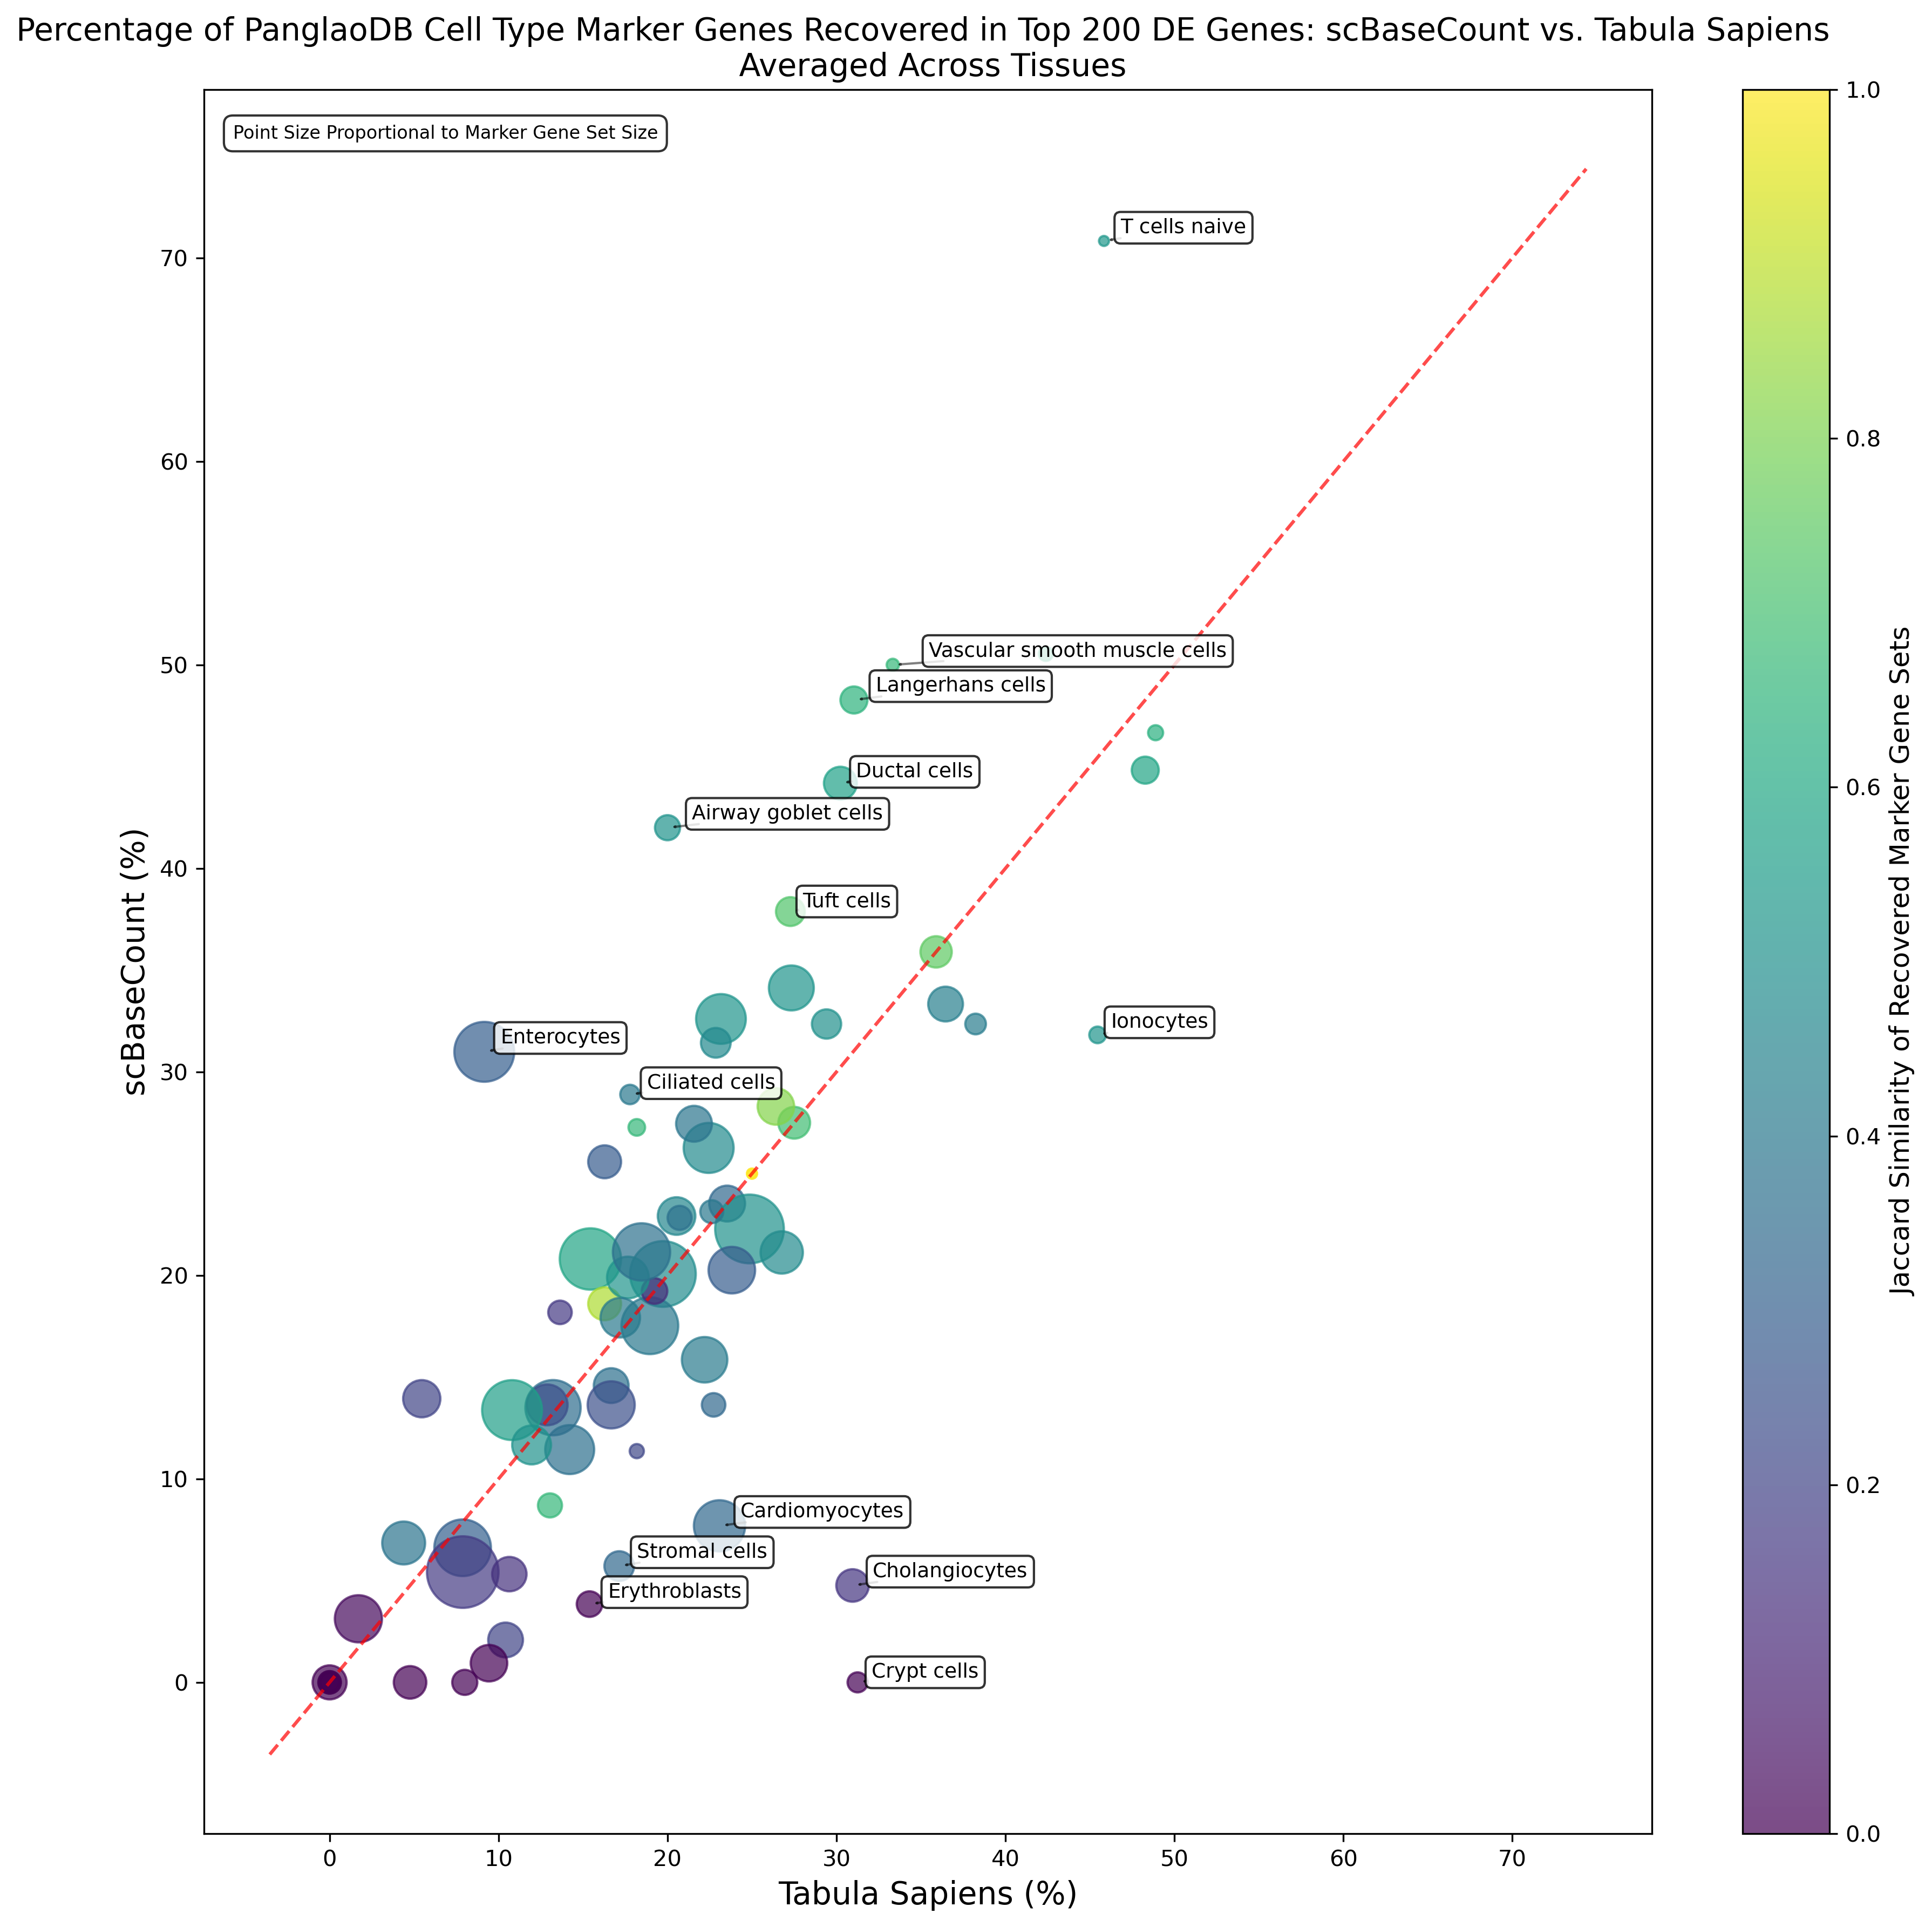

In [13]:
plt.rcParams.update({'figure.dpi': 300})
fig, ax = plt.subplots(figsize=(12, 12)) 

scatter = ax.scatter(x=avg_df['Tabula Sapiens'].values * 100, 
                   y=avg_df['scBaseCount'].values * 100, 
                   c=avg_df['Jaccard Shared'].values,
                   cmap='viridis',
                   s=avg_df['marker_count'] * 5,  # Larger points
                   alpha=0.7)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Jaccard Similarity of Recovered Marker Gene Sets', fontsize=12)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
line_min = min(x_min, y_min)
line_max = max(x_max, y_max)
ax.plot([line_min, line_max], [line_min, line_max], color='red', linestyle='--', alpha=0.7)

texts = []
for idx, row in avg_df.iterrows():
   x_val = row['Tabula Sapiens'] * 100
   y_val = row['scBaseCount'] * 100
   
   # Calculate perpendicular distance from x=y line
   perpendicular_distance = abs(x_val - y_val) / np.sqrt(2)
   
   if (perpendicular_distance > 7):
       text = ax.text(x_val, y_val, idx, fontsize=9, 
                     bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
       texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
ax.set_xlabel('Tabula Sapiens (%)', fontsize=14)  # Added %
ax.set_ylabel('scBaseCount (%)', fontsize=14)     # Added %
ax.set_title('Percentage of PanglaoDB Cell Type Marker Genes Recovered in Top 200 DE Genes: scBaseCount vs. Tabula Sapiens \n Averaged Across Tissues', fontsize=14)
plt.tight_layout()
plt.savefig("images/marker_gene_scatter_plot_08_16.svg", 
           format='svg',
           bbox_inches='tight',
           facecolor='white',
           edgecolor='none')
ax.text(0.02, 0.98, 'Point Size Proportional to Marker Gene Set Size', 
        transform=ax.transAxes, 
        fontsize=8,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

plt.show()